In [1010]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio
import seaborn as sns

%matplotlib inline

# Optionally, tweak styles.
rc('animation', html='html5')
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import glob
from sxmreader import SXMReader

Params = namedtuple(
    'Params', 
    ['molecule_size', 
     'min_mass',
     'max_mass',
     'separation',
     'min_size',
     'max_ecc',
     'adaptive_stop',
     'search_range'])

voltage = np.linspace(0.41, 0.51, 6, dtype=np.float32)
START = 776
SIZE = 15
sets = [range(START + SIZE * i, START + SIZE * (i + 1)) for i in range(len(voltage))]
params = [
     Params(molecule_size = 11,
            min_mass = 2,
            max_mass = 8,
            min_size = 0.5,
            max_ecc = 1,
            separation = 5,
            search_range = 50,
            adaptive_stop = 2
            #molecule_size = 9,
            #min_mass = 1,
            #max_mass = 8,
            #min_size = 0.5,
            #max_ecc = 1,
            #separation = 5,
            #search_range = 50,
            #adaptive_stop = 5
           ) for i in range(len(voltage))
         ]
n_range = [i for i in sets]
n_range = [range(897,912), range(912,927) ,range(776, 791), range(791, 806), range(806, 821), range(821, 836)]
N = [len(i) for i in sets]
N= [len(i) for i in n_range]
SXM_PATH = [["electromigration_19/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]

In [1033]:
drifts = []
D_constants = []
mu_hats = []
v = []
for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    #new_frames = []
    NM_PER_PIXEL = frames.meters_per_pixel * 1e9 
    #for j, frame in enumerate(frames):
    #    new_frames.append(frame[128:255,:]) #(y,x)
    #if i==1:
    #    frames.z_data[5][158,:] = 0
    #    frames.z_data[4][156,:] = 0
    #    frames.z_data[4][155,:] = 0
    #    frames.z_data[4][151,:] = 0
    molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range = params[i]
    f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop)
#     t = tp.link(f, search_range=search_range)
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 3)
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t2['particle'].nunique())
    d = tp.compute_drift(t2)
    t3 = t2.copy()
    displacements = tp.relate_frames(t3, 0, 1) * NM_PER_PIXEL
    for j in range(t3.frame.max() - 1):
        displacements = displacements.append(tp.relate_frames(t3, j, j + 1) * NM_PER_PIXEL, ignore_index=True)
    D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
    d.loc[0] = [0, 0]
    drifts.append(d)
    
    em = tp.emsd(t3, frames.meters_per_pixel*1e9, DIFFUSION_TIME, max_lagtime=15 ,detail=True)
    v.append([em['<x>'],em['<y>']])

    # print(d)

Frame 14: 24 trajectories present.
Before: 44
After: 30


In [1018]:
scatter_displacement = [[np.array([]), np.array([])] for i in range(len(frames))]
for i in range(len(frames)-1):
    for j in range(i+1, len(frames)-1):
        vals = [tp.relate_frames(t3,i,j)['dx'].values * NM_PER_PIXEL,tp.relate_frames(t3,i,j)['dy'].values * NM_PER_PIXEL]
        scatter_displacement[j-i] = np.concatenate([scatter_displacement[j-i], vals], axis =1)

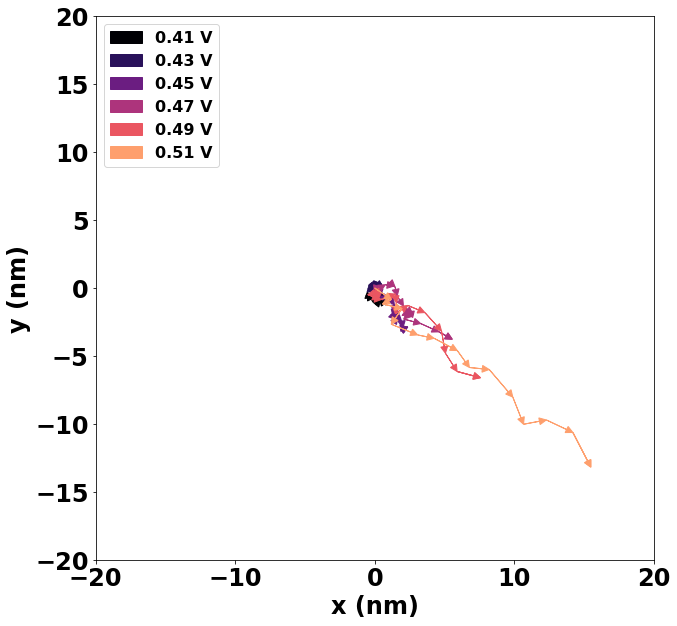

In [1023]:
mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(10, 10))
#colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
cmap = plt.cm.get_cmap("magma")
colors = cmap(np.linspace(0,0.8,len(voltage)))

arrs = []
j = 0
for d in drifts:
    d['y'] = d['y']*-1
#     sns.scatterplot(x='x', y='y', data=d * NM_PER_PIXEL, alpha=0.0)
    for i in range(1, len(d)):
        d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
        plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', color=colors[j], length_includes_head=True, 
        zorder=0, head_length=0.5, head_width=0.5,linewidth=1)
    else:
        d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
        arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
        shape='full', color=colors[j], length_includes_head=True, 
        zorder=0, head_length=0.5, head_width=0.5, label=str(voltage[j])))
    j += 1
new_labels, arrs = zip(*sorted(zip(voltage, arrs)))
new_labels=["{:.2f}".format(s) + ' V' for s in new_labels]
plt.legend(arrs, new_labels, fontsize=16, loc='upper left')
#plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

In [1028]:
def calculate_mean_axis(mu_hats):
    return sum(mu_hats)/len(mu_hats)
mean_mu_hat = calculate_mean_axis(mu_hats)

def project_to_mean_axis(mu_hats, mean_mu_hat):
    return [np.dot(v,mean_mu_hat) for v in mu_hats]

In [1029]:
mag_displace/DIFFUSION_TIME

array([0.0881857 , 0.01721636, 0.30606802, 0.41797495, 0.71354962,
       1.37261721])

Text(0.5, 0, 'Voltage (V)')

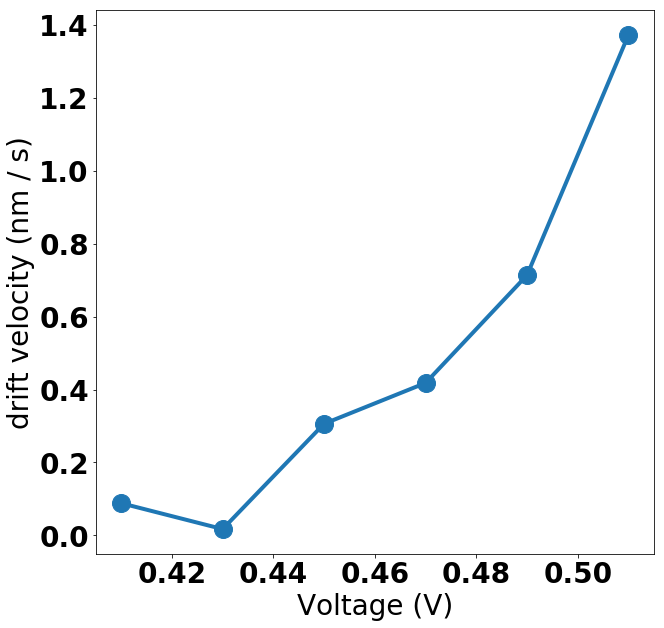

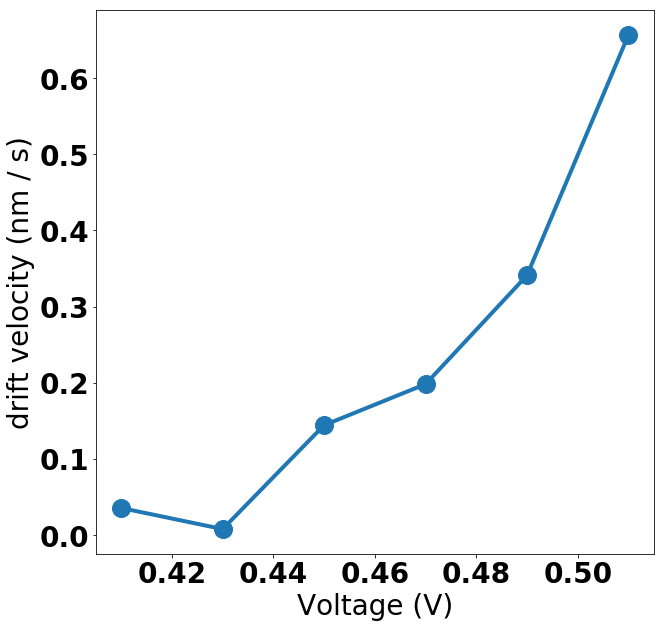

In [1027]:
import scipy
DIFFUSION_TIME = 1 # in seconds
mag_displace = np.linalg.norm(mu_hats, 2, axis=1)
new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltage, mag_displace, D_constants)))
import matplotlib
matplotlib.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace / DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
# plt.plot(xx, yy / 1.5)
plt.ylabel('drift velocity (nm / s)')
plt.xlabel('Voltage (V)')



plt.figure(figsize=(10, 10))
proj_mag_displace = np.array(project_to_mean_axis(mu_hats,mean_mu_hat))
plt.plot(voltage,  proj_mag_displace / DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
plt.ylabel('drift velocity (nm / s)')
plt.xlabel('Voltage (V)')

Text(0.5, 0, 'Voltage (V)')

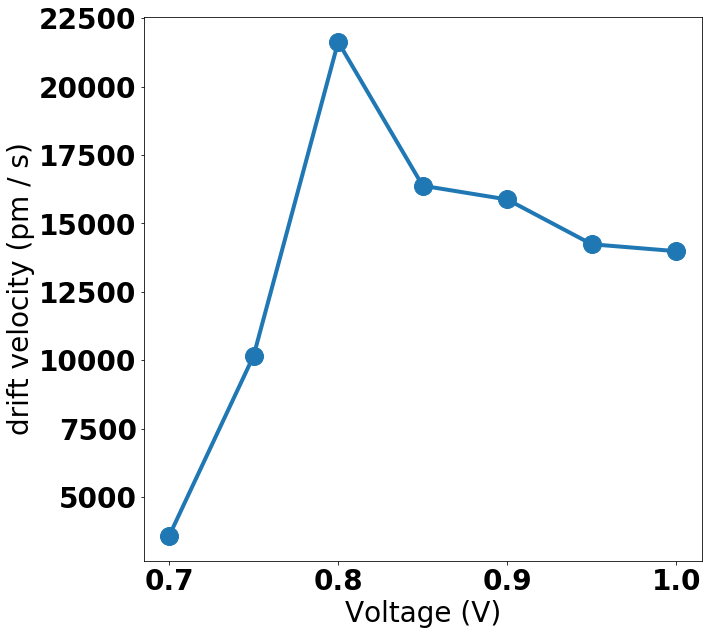

In [187]:
import scipy
DIFFUSION_TIME = 1 # in seconds
endpoints = np.array([d.iloc[-2] * NM_PER_PIXEL / DIFFUSION_TIME for d in drifts])
mag_displace = np.linalg.norm(endpoints, 2, axis=1)
new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(voltage, mag_displace, D_constants)))
def exponential_func(x, a, b):
    return a*np.exp(-b*x)

# popt, pcov = scipy.optimize.curve_fit(exponential_func, new_labels, mag_displace)

# xx = np.linspace(0.9, 1.4, 100)
# yy = exponenial_func(xx, *popt)
import matplotlib
matplotlib.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace * 1e3, '-o', markersize=18, linewidth=4)
# plt.plot(xx, yy / 1.5)
plt.ylabel('drift velocity (pm / s)')
plt.xlabel('Voltage (V)')

In [77]:
ds = [0.01879390399510874,
 0.05081455484071236,
 0.1422569480594092,
 0.22665997294778575,
 0.43412316193393957]
plt.figure(figsize=(10, 10))
plt.plot(voltage, mag_displace / ds)
plt.xlabel('voltage')

ValueError: operands could not be broadcast together with shapes (6,) (5,) 

<Figure size 720x720 with 0 Axes>

NameError: name 'exponential_func' is not defined

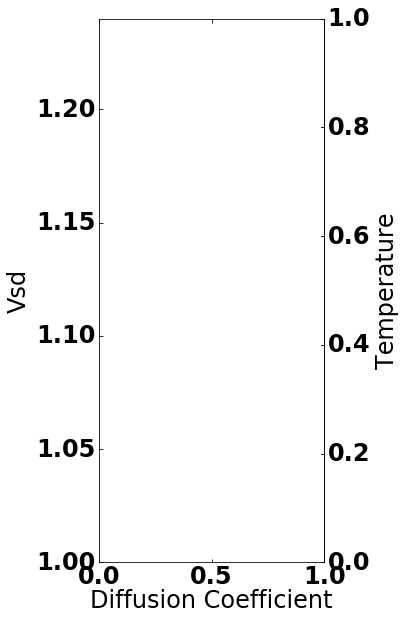

In [78]:
"""
Parasite axis demo

The following code is an example of a parasite axis. It aims to show a user how
to plot multiple different values onto one single plot. Notice how in this
example, par1 and par2 are both calling twinx meaning both are tied directly to
the x-axis. From there, each of those two axis can behave separately from the
each other, meaning they can take on separate values from themselves as well as
the x-axis.
"""
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Diffusion Coefficient")
host.set_ylabel("Vsd")
host.set_ylim(1, 1.24)
par1.set_ylabel("Temperature")
par2.set_ylabel("Temperature")
Vsd = np.abs(np.array([-1.3, -1.225, -1.15, -1.075, -1.0]))

v_d = np.array([17.43212689649283,
         11.777233189697016,
         4.366861338228251,
         1.7498151858787845,
         0.6145379907911179])
popt, pcov = scipy.optimize.curve_fit(exponential_func, Vsd, v_d)

v_xx = np.linspace(1, 1.3, 100)
v_yy = exponential_func(v_xx, *popt)
p1, = host.plot(v_d, Vsd, 'bo', label="Vsd")
p1_fit, = host.plot(v_yy, v_xx, label="Vsd_fit")
temp = np.array([16.0, 17.0, 18.0, 19.0, 20.0])
temp_d = np.array([0.8248499990567321,
         1.1601072114062563,
         3.135702343676707,
         6.368734022432294,
         10.3054668679748])
popt, pcov = scipy.optimize.curve_fit(exponential_func, temp, temp_d)

t_xx = np.linspace(16, 20, 100)
t_yy = exponential_func(t_xx, *popt)
p2, = par2.plot(temp_d, temp, 'ro', label="Temperature")
p2_fit, = par2.plot(t_yy, t_xx, label="Temperature Fit")
par1.set_ylim(16, 20)
host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()

# WAIT TIME ANALYSIS

In [264]:
t4 = t3.drop(columns='frame').reset_index().sort_values(['particle', 'frame'])
t4['step_y'] = t4.groupby('particle').diff()['y']
t4['step_x'] = t4.groupby('particle').diff()['x']

(-10, 10)

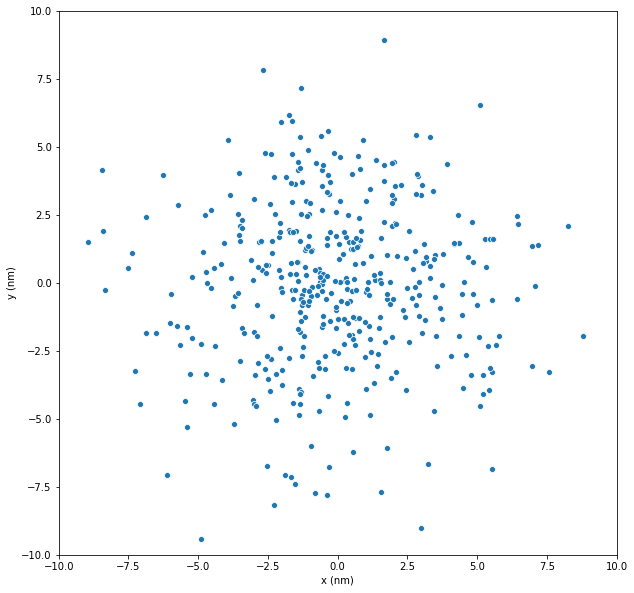

In [265]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='step_x', y='step_y', data=t4 * NM_PER_PIXEL)
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [278]:
t4[t4.particle == 2]

KeyboardInterrupt: 

vx=0.86nm/s
vy=0.46nm/s


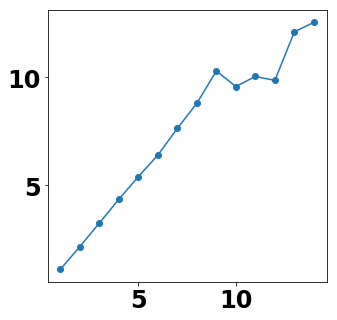

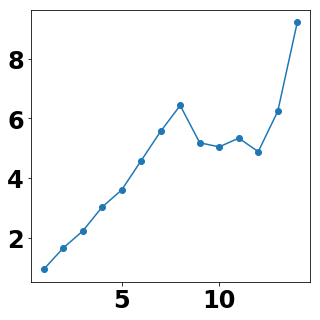

In [1017]:
em = tp.emsd(t3, frames.meters_per_pixel*1e9, DIFFUSION_TIME, max_lagtime=15 ,detail=True)
mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(5, 5))
plt.plot(range(1,15),em['<x>'],'o-')
plt.figure(figsize=(5, 5))
plt.plot(range(1,15),em['<y>'],'o-')
t = [i for i in range(1,15)]
slope, intercept, _, _, _ = stats.linregress(t,em['<x>'])
print("vx={:.2f}nm/s".format(slope))
slope, intercept, _, _, _ = stats.linregress(t,em['<y>'])
print("vy={:.2f}nm/s".format(slope))

In [277]:
t4['step_size'] = np.sqrt(t4['step_x'] ** 2 + t4['step_y'] ** 2)
t4['big_step'] = t4['step_size'] > 10
a = ~t4['big_step']
b = a.cumsum()
c = b-b.where(~a).ffill().fillna(1).astype(int)
t4['wait'] = c
t4['wait'] = t4['wait'].replace(0, np.nan).ffill(limit=1)
t4[t4['big_step']].dropna()

,frame,y,x,mass,size,ecc,signal,raw_mass,ep,particle,step_y,step_x,step_size,big_step,wait
72,2,174.098734,39.690340,4.808615,1.830630,0.093042,0.369189,14.487905,-1.172080,2,-10.081164,6.290360,11.882697,True,17.0
229,6,158.248674,33.150365,4.715513,1.801042,0.192747,0.374976,14.515177,-0.966156,2,-11.339132,-4.092308,12.054995,True,3.0
402,12,212.608462,14.802080,4.760476,1.791610,0.163146,0.374454,13.812615,-0.620764,2,14.306489,-0.865293,14.332632,True,1.0
182,5,195.301694,97.477209,4.701746,1.843765,0.202021,0.366593,20.643393,0.374027,3,9.568686,4.251453,10.470654,True,7.0
248,7,190.415212,104.189439,4.666769,1.778071,0.221526,0.375381,21.852424,0.314147,3,-6.905670,10.350241,12.442499,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,13,227.315411,178.502980,4.789136,1.720998,0.055577,0.390135,29.978425,0.136142,46,0.603529,-13.413194,13.426765,True,5.0
381,11,112.923520,152.648532,4.625103,1.758631,0.238251,0.381452,25.724478,0.165563,47,-10.487403,13.330128,16.961071,True,2.0
464,14,133.032353,129.325124,4.561296,1.730998,0.146539,0.373554,25.029457,0.196148,47,10.613575,-21.625339,24.089484,True,2.0
412,12,103.788411,227.107142,4.748199,1.724852,0.143991,0.386731,34.964996,0.083019,48,-12.947515,-5.680163,14.138684,True,1.0


(-50, 50)

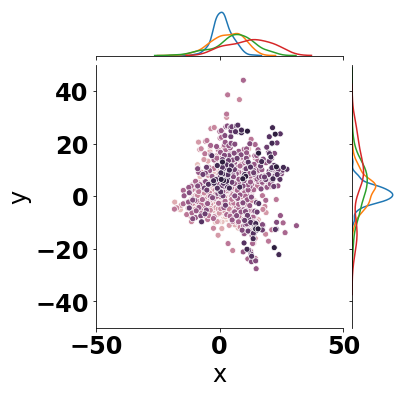

In [1020]:
scatter_df=pd.DataFrame(data=scatter_displacement, columns = ['x','y'])
scatter_df['interval'] = [i for i in range(0,len(frames))]
scatter_df = explode(scatter_df, lst_cols=list('xy'))
filtered_scatter_df = scatter_df[scatter_df['x'].map(type)!=str]
scatter_df = filtered_scatter_df
grid = sns.JointGrid(x='x', y='y', data=scatter_df)
g = grid.plot_joint(sns.scatterplot, hue='interval', data=scatter_df)
sns.kdeplot(scatter_df.loc[scatter_df['interval']== 1 , 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==3, 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==6, 'x'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==13, 'x'], ax=g.ax_marg_x, legend=False)

sns.kdeplot(scatter_df.loc[scatter_df['interval']==1, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==3, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==6, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(scatter_df.loc[scatter_df['interval']==13, 'y'], ax=g.ax_marg_y, vertical=True, legend=False)

plt.legend().remove()
plt.xlim([-50,50])
plt.ylim([-50,50])

/home/a/as/asai/dsgo/trading/trading/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/home/a/as/asai/dsgo/trading/trading/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]


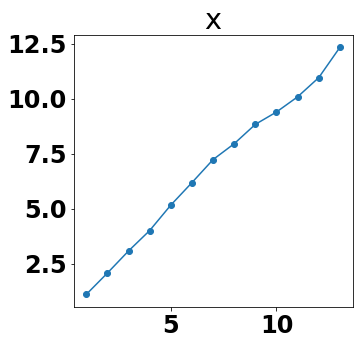

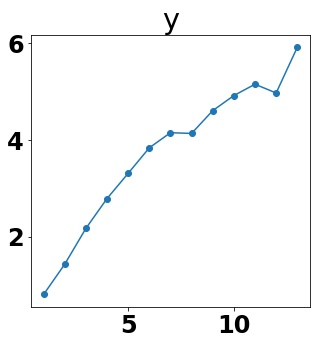

In [1021]:
mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(5, 5))
cmap = plt.cm.get_cmap("magma")
colors = cmap(np.linspace(0,0.8,len(frames)))
x_vals = []
y_vals = []
for i in range(1, len(frames)):
    plot_x = scatter_displacement[i][0]
    plot_x = plot_x[~np.isnan(plot_x)]
    plot_y = scatter_displacement[i][1]
    plot_y = plot_y[~np.isnan(plot_y)]
    x_vals.append(plot_x.mean())
    y_vals.append(plot_y.mean())
    #plt.scatter(scatter_displacement[i][0],scatter_displacement[i][1])
    #plt.scatter(plot_x.mean(),plot_y.mean(),color=colors[i])
plt.plot(range(1,15),x_vals,'o-')
plt.title('x')
plt.figure(figsize=(5, 5))
plt.title('y')
plt.plot(range(1,15),y_vals,'o-')

In [1019]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

vx=0.06nm/s
vy=0.04nm/s
vx=0.01nm/s
vy=-0.03nm/s
vx=0.13nm/s
vy=0.20nm/s
vx=0.48nm/s
vy=0.38nm/s
vx=0.54nm/s
vy=0.34nm/s
vx=1.12nm/s
vy=0.66nm/s


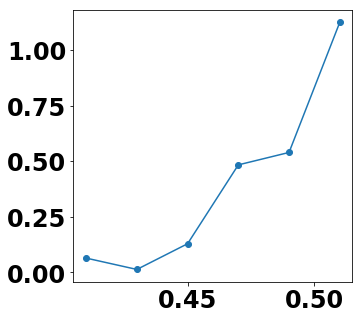

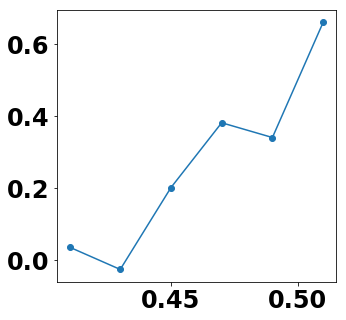

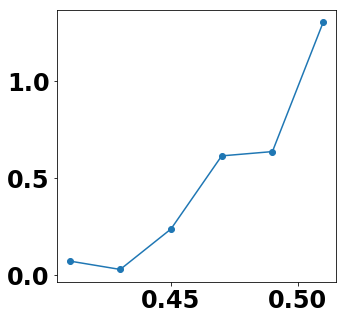

In [1016]:
t = [i for i in range(1,len(frames))]
vx = []
vy = []
for i, volt in enumerate(voltage):
    slope, intercept, _, _, _ = stats.linregress(t[:-5],v[i][0][:-5])
    print("vx={:.2f}nm/s".format(slope))
    vx.append(slope)
    slope, intercept, _, _, _ = stats.linregress(t[:-5],v[i][1][:-5])
    print("vy={:.2f}nm/s".format(slope))
    vy.append(slope)
mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(5, 5))
plt.plot(voltage,vx,'o-')
plt.figure(figsize=(5, 5))
plt.plot(voltage,vy,'o-')
plt.figure(figsize=(5, 5))
plt.plot(voltage,np.sqrt(np.array(vx)**2 + np.array(vy)**2),'o-')